<a href="https://colab.research.google.com/github/UselessEntity/langgraph_b4s1c/blob/master/LangGraph_b4s1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download necessary packages

In [1]:
!pip install --upgrade --quiet pip
!pip install --upgrade langchain langgraph langchain-core langchain-community langsmith langgraph-cli langchain-openai langchain-anthropic langchain-xai
!pip install --upgrade transformers datasets bitsandbytes
!pip install dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.4.4
    Uninstalling langsmith-0.4.4:
      Successfully uninstalled langsmith-0.4.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.68
    Uninstalling langchain-core-0.3.68:
      Successfully uninstalled langchain-core-0.3.68
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20/20 [langchain-community]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 137.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 148.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import userdata
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_TOKEN"] = userdata.get("GROQ_TOKEN")
os.environ["LANGSMITH_TOKEN"] = userdata.get("LANGSMITH_TOKEN")
os.environ["GITHUB_TOKEN"] = userdata.get("GITHUB_TOKEN")

In [3]:
import os
import operator
import random
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Dict, List, Literal

# I. State, Graph, Node đơn giản

In [4]:
# Một State đơn giản:
class GameState(TypedDict):
  game: str
  message: str
  message_2: str

# Tạo một node đơn giản:
def game_node(state: GameState) -> GameState: # Cái này là cập nhật & trả về trạng thái State sau khi cập nhật
  """Node đơn giản để thêm thông tin về games"""

  state['message'] = "Hey " + state['message'] + ", wanna play some games?"
  return state

def new_game(state: GameState) -> GameState:
  game = state['game']
  state['message_2'] = f"Let's play {game}!"
  return state

In [5]:
# Để là workflow, builder hay gì cũng đc, chỉ cần gắn giá trị đúng thôi
builder = StateGraph(GameState)

builder.add_node("Game", game_node) # Thêm node phải có 2 giá trị: Tên của node & node hiện tại
builder.add_node("Tekken_8", new_game)

builder.add_edge("Game", "Tekken_8")
builder.add_edge("Tekken_8", END)

In [6]:
# Thêm node khởi chạy & node cuối trình chạy của graph (chưa phải END node)
builder.set_entry_point("Game")
builder.set_finish_point("Tekken_8")

game_console = builder.compile() # Bắt buộc phải có compile thì sau đó mới chạy được code

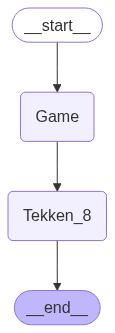

In [7]:
from IPython.display import Image, display
display(Image(game_console.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [8]:
result = game_console.invoke({"message": "Narrator", "game": "Tekken_8"}) # Chạy graph vừa được khởi tạo
print(result)

{'game': 'Tekken_8', 'message': 'Hey Narrator, wanna play some games?', 'message_2': "Let's play Tekken_8!"}


# Áp dụng làm một task với State đơn giản

In [9]:
# Tạo State
class Task1State(TypedDict):
  current_node: str
  name: str
  compliment: str

# Tạo ra node
def compliment_setup(state: Task1State) -> Task1State:
    """
    Tạo ra node đơn giản để thực hiện task
    Task ở đây: Tạo ra một Personalized Compliment Agent
    Input: {name: "Bob"}
    Output: "Bob, you're doing an amazing job at learning Langgraph!"
    """
    # print(state)
    name = state['name']
    state['compliment'] = f"Hey {state['name']}, you're doing an amazing job at learning Langgraph! Your curent node is: {state['current_node']}"
    # print(state)
    return state

# Tạo ra graph workflow chính
workflow = StateGraph(Task1State)

workflow.add_node("Compliment", compliment_setup)

workflow.set_entry_point("Compliment")

workflow.add_edge("Compliment", END)

new_compliment = workflow.compile()

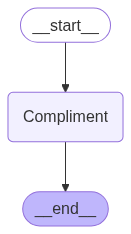

In [10]:
# Show flow dưới dạng graph
from IPython.display import Image, display
display(Image(new_compliment.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [11]:
# Invoke để chạy graph (vì đây là workflow), chứ ko phải chạy State
def invoke_result(input_data: dict) -> str:
  result = new_compliment.invoke(input_data)
  return result['compliment']

input = {"name": "Bob", "current_node": "Compliment"}
output = invoke_result(input)
print(output)

Hey Bob, you're doing an amazing job at learning Langgraph! Your curent node is: Compliment


# Tiếp tục & thử làm để test

In [12]:
class AgeState(TypedDict):
  name: str
  values: list[int]
  operation: str
  result: str

def node_1(state: AgeState) -> AgeState:
  name = state['name']
  values = state['values']
  operation = state['operation']

  if operation == "+":
    result = sum(values)
  elif operation == "*":
    result = 1
    for num in values:
      result *= num
  else:
    result = 0

  state['result'] = f"Hi {state['name']}. You're {result} years old."
  return state

workflow = StateGraph(AgeState)

workflow.add_node("calculation_node", node_1)

workflow.set_entry_point("calculation_node")

workflow.add_edge("calculation_node", END)

human_age = workflow.compile()

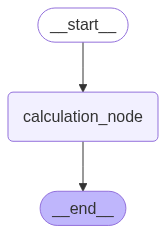

In [13]:
from IPython.display import Image, display
display(Image(human_age.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [14]:
input_data = {
    "name": "Jack",
    "values": [1,2,3,5],
    "operation": "*"
}

input_data_2 = {
    "name": "Jack",
    "values": [1,2,3,5],
    "operation": "+"
}

result = human_age.invoke(input_data_2)
print(result['result'])

Hi Jack. You're 11 years old.


In [15]:
class AgentState(TypedDict):
  name: str
  age: str
  result: str

In [16]:
def first_node(state: AgentState) -> AgentState:
  """Node đầu tiên trong chuỗi"""
  state['result'] = f"Hi {state['name']}."
  return state

def second_node(state: AgentState) -> AgentState:
  """Node thứ hai trong chuỗi"""
  state['result'] = state['result'] + f"You're {state['age']} years old." # Kết hợp hai node với nhau cùng lúc
  return state

In [17]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("first_node", first_node)
graph_builder.add_node("second_node", second_node)

graph_builder.set_entry_point("first_node")

graph_builder.add_edge("first_node", "second_node")
graph_builder.set_finish_point("second_node")

agent_graph = graph_builder.compile()

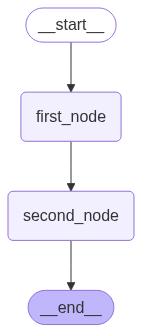

In [18]:
from IPython.display import Image, display
display(Image(agent_graph.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [19]:
result = agent_graph.invoke({"name": "Bob", "age": "21"})
print(result['result'])

Hi Bob.You're 21 years old.


In [20]:
class UserState(TypedDict):
  name: str
  age: str
  skills: str
  skills_list: List[str] # Add a new key for the input skills list

def name_node(state: UserState) -> UserState:
  name = state['name']
  state['skills'] = f"Hi {name}. Gladly meeting you here."
  return state

def age_node(state: UserState) -> UserState:
  age = state['age']
  state['skills'] = state['skills'] + f" You're {age} years old. You died young and got reincarnated to this new world."
  return state

def skill_node(state: UserState) -> UserState:
  # Use the skills_list from the input
  skills = ", ".join(state['skills_list'])
  state['skills'] = state['skills'] + f" You can choose these new skills: {skills} to start at this world."
  return state

isekai = StateGraph(UserState)

isekai.add_node("name_node", name_node)
isekai.add_node("age_node", age_node)
isekai.add_node("skill_node", skill_node)

isekai.set_entry_point("name_node")

isekai.add_edge("name_node", "age_node")
isekai.add_edge("age_node", "skill_node")
isekai.set_finish_point("skill_node")

isekai_character = isekai.compile()

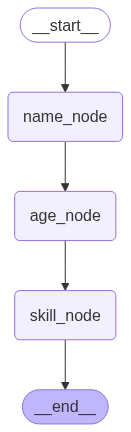

In [21]:
from IPython.display import Image, display
display(Image(isekai_character.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [22]:
input_data = {
    "name": "Jachiru",
    "age": "38",
    "skills_list": ["self_heal", "power_up_x100", "big_brain", "thief", "all_seeing"]
}

new_character = isekai_character.invoke(input_data)
print(new_character['skills'])

Hi Jachiru. Gladly meeting you here. You're 38 years old. You died young and got reincarnated to this new world. You can choose these new skills: self_heal, power_up_x100, big_brain, thief, all_seeing to start at this world.


# Router + conditional edges

In [23]:
class MathState(TypedDict):
  number_1: int
  number_2: int
  number_3: int
  number_4: int
  operation: str
  operation_2: str
  final_number: int
  final_number_2: int

In [24]:
def addition(state: MathState) -> MathState:
  """
  Cộng 2 số với nhau
  """
  state['final_number'] = state['number_1'] + state['number_2']
  return state

def substraction(state: MathState) -> MathState:
  """ Trừ 2 số với nhau """
  state['final_number'] = state['number_1'] - state['number_2']
  return state

def decide_next_node(state: MathState) -> MathState:
  """ Node để chọn các node tiếp theo cho graph """
  if state['operation'] == "+":
    return "addition_operation"
  elif state['operation'] == "-":
    return "subtraction_operation"
  else:
    return "invalid_operation"

#----------------------------------------------------------------------#

def addition_2(state: MathState) -> MathState:
  """ Nhân 2 số với nhau """
  state['final_number_2'] = state['number_3'] + state['number_4']
  return state

def subtraction_2(state: MathState) -> MathState:
  """ Chia 2 số với nhau """
  state['final_number_2'] = state['number_3'] - state['number_4']
  return state

def decide_next_node_2(state: MathState) -> MathState:
  """ Node để chọn các node tiếp theo cho graph """
  if state['operation_2'] == "+":
    return "addition_operation_2"
  elif state['operation_2'] == "-":
    return "subtraction_operation_2"
  else:
    return "invalid_operation"

In [25]:
graph = StateGraph(MathState)

graph.add_node("add_node", addition)
graph.add_node("subtract_node", substraction)
graph.add_node("router", lambda state:state) # Passthrough function

graph.add_node("add_node_2", addition_2)
graph.add_node("subtract_node_2", subtraction_2)
graph.add_node("router_2", lambda state:state)
# graph.add_node("router", decide_next_node) ## Này sẽ sinh lỗi

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node, # Hàm để routing
    {
        # Edge: Node
        "addition_operation": "add_node",
        "subtraction_operation": "subtract_node"
    }
)

graph.add_edge("add_node", "router_2")
graph.add_edge("subtract_node", "router_2")

graph.add_conditional_edges(
    "router_2",
    decide_next_node_2,
    {
        "addition_operation_2": "add_node_2",
        "subtraction_operation_2": "subtract_node_2"
    }
)

graph.add_edge("add_node_2", END)
graph.add_edge("subtract_node_2", END)

math_app = graph.compile()

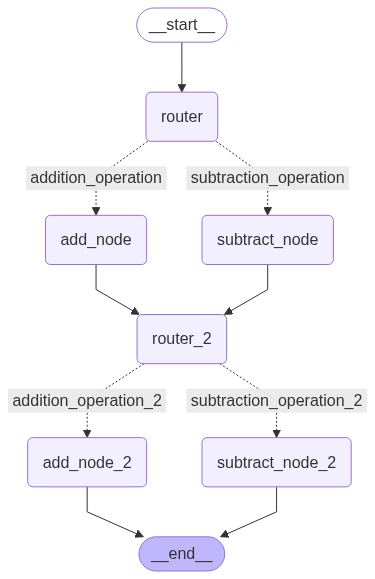

In [26]:
from IPython.display import Image, display
display(Image(math_app.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [27]:
# Gọi invoke trực tiếp
## Kiểu 1:
# initial_state = MathState(number_1 = 10, number_2 = 2, operation = "+")
# print(math_app.invoke(initial_state)['final_number'])

## Kiểu 2:
# initial_state = math_app.invoke({"number_1": 10, "number_2": 5, "operation": "+"})
# print(initial_state['final_number'])

# Khởi tạo dict để invoke graph
# input_1 = {
#     "number_1": 10,
#     "number_2": 5,
#     "operation": "+"
# }

# input_2 = {
#     "number_1": 12,
#     "number_2": 2,
#     "operation": "-"
# }
# # Tạo list inputs
# inputs = [input_1, input_data_2]
# # inputs = []

# # Lặp qua inputs & invoke qua từng thằng một
# results = []
# for input_item in inputs:
#   result = math_app.invoke(input_item)
#   results.append(result)

# # In kết quả
# for i, result in enumerate(results):
#     print(f"Input {i+1}: {inputs[i]} -> Result: {result['final_number']}")

In [28]:
# initial_state = MathState(number_1 = 10, number_2 = 2, operation = "+", number_3 = 4, number_4 = 2, operation_2 = "-", final_number=0, final_number_2=0)
# print(math_app.invoke(initial_state))

# Cách tạo kiểu dict, nhớ phải có hết các giá trị đã tạo trong State
input_1 = {
    "number_1": 10,
    "number_2": 5,
    "operation": "+",
    "number_3": 4,
    "number_4": 2,
    "operation_2": "-",
    "final_number": 0,
    "final_number_2": 0
}

input_2 = {
    "number_1": 12,
    "number_2": 2,
    "operation": "-",
    "number_3": 8,
    "number_4": 3,
    "operation_2": "+",
    "final_number": 0,
    "final_number_2": 0
}

# Tạo list inputs
inputs = [input_1, input_2]

# Lặp qua inputs & invoke qua từng thằng một
results = []
for input_item in inputs:
    result = math_app.invoke(input_item)
    results.append(result)

# In kết quả
for i, result in enumerate(results):
    print(f"Input {i+1}: {inputs[i]}")
    print(f"  -> Router 1 result: {result['final_number']}")
    print(f"  -> Router 2 result: {result['final_number_2']}")
    print()

Input 1: {'number_1': 10, 'number_2': 5, 'operation': '+', 'number_3': 4, 'number_4': 2, 'operation_2': '-', 'final_number': 0, 'final_number_2': 0}
  -> Router 1 result: 15
  -> Router 2 result: 2

Input 2: {'number_1': 12, 'number_2': 2, 'operation': '-', 'number_3': 8, 'number_4': 3, 'operation_2': '+', 'final_number': 0, 'final_number_2': 0}
  -> Router 1 result: 10
  -> Router 2 result: 11



# Thực hành làm exercise tiếp, tạo looping logic

In [192]:
from langchain_core.runnables import RunnableConfig
class GameState(TypedDict):
  player_name: str
  hint: str
  target_number: int
  guesses: List[int]
  attempts: int
  lower_bound: int
  higher_bound: int
  won: bool
  game_over: bool

In [193]:
def initialize_game(state: GameState) -> GameState:
  state["attempts"] = 0
  state["lower_bound"] = 1
  state["higher_bound"] = 100
  state["guesses"] = []
  state["target_number"] = random.randint(state["lower_bound"], state["higher_bound"])
  state["won"] = False
  state["game_over"] = False
  state["hint"] = f"Hi {state['player_name']}. I want to introduce you to this game. It's called Higher-Lower number guessing. Try to guess the number in the range of 1 to 100."
  print(state["hint"])
  return state

In [194]:
def guess_node(state: GameState) -> GameState:
  """Generate a smarter guess based on previous hint"""
  try:
    possible_guess = int(__builtins__.input(f"Attempt {state['attempts'] + 1}: Enter your guess: "))
    if possible_guess < state["lower_bound"] or possible_guess > state["higher_bound"]:
      state["hint"] = f"Dude, you shoule know the range of number is between {state['lower_bound']} and {state['higher_bound']}. Try guessing again."
      print(state["hint"])
      return state
    if possible_guess in state["guesses"]:
      state["hint"] = f"You have already guessed {possible_guess}. Try a different number, dude. You're not dumb 😑"
      print(state["hint"])
      return state

    # Thêm valid guess:
    state["guesses"].append(possible_guess)
    state["attempts"] += 1
  except Exception as e:
    state["hint"] = "Invalid guess, dude. You need to guess a number! Guess again."
    print(state["hint"])
    return state

  return state

In [195]:
def check_guess(state: GameState) -> GameState:
  """
  Check if the guess is correct, too high, or too low
  """
  if not state['guesses']:
    return state

  current_guess = state["guesses"][-1]
  target_number = state["target_number"]

  if current_guess == target_number:
    state["hint"] = f"Congrats. The number is {target_number}, you guess is correct, pal. You win! 🎊"
    state["game_over"] = True # Set game_over to True on win
    state["won"] = True
    print(state["hint"])
    return state

  if current_guess < target_number:
    state["lower_bound"] = max(state["lower_bound"], current_guess + 1)
    state["hint"] = "Too low, dude. Try again."
  else:
    state["higher_bound"] = min(state["higher_bound"], current_guess - 1) # Corrected typo here
    state["hint"] = "Too high, dude. Try again."
  print(state["hint"])
  return state

In [196]:
def check_game_over(state: GameState) -> GameState:
  """Check to see if the game should end due to too many attempts"""
  max_attempts = 7
  if state["attempts"] >= max_attempts and not state["won"]:
        state["hint"] = f"Game Over! You've used all {max_attempts} attempts. The number was {state['target_number']}."
        state["game_over"] = True # Ensure game_over is True when attempts run out
        state["won"] = False  # Để thành False tượng trưng cho việc thua
        print(state["hint"])
  elif state["attempts"] < max_attempts and not state["game_over"]:
        # Hiện ra còn bao nhiêu lần thử nữa
        remaining = max_attempts - state["attempts"]
        print(f"You have {remaining} attempts remaining.")

  return state

In [197]:
def end_game(state: GameState) -> GameState:
  """End game"""
  if state["won"]:
    print(f"Again, congratulations! You, player {state['player_name']}, have won the game in {state['attempts']} guesses! 🎉")
  else:
    print("Ah, you lose. Better luck next time. 🤡")

  print(f"Your guesses were: {state['guesses']}")
  print(f"Total attempts used: {state['attempts']}/7")
  return state

In [198]:
def should_continue(state: GameState) -> Literal["inf_loop", "end_game"]:
  """Determined the next node based on the game state"""
  if state["game_over"]:
    return "end_game"
  else:
    return "inf_loop"

In [199]:
def create_game_graph(state: GameState) -> GameState:
  game = StateGraph(GameState)

  game.add_node("initialize", initialize_game)
  game.add_node("get_guess", guess_node)
  game.add_node("check_guess", check_guess)
  game.add_node("is_jover?", check_game_over)
  game.add_node("the_end", end_game)

  game.set_entry_point("initialize")
  game.add_edge("initialize", "get_guess")
  game.add_edge("get_guess", "check_guess")
  game.add_edge("check_guess", "is_jover?")

  game.add_conditional_edges(
      "is_jover?",
      should_continue,
      {
          "inf_loop": "get_guess",
          "end_game": "the_end"
      }
  )

  game.add_edge("the_end", END)
  return game.compile()

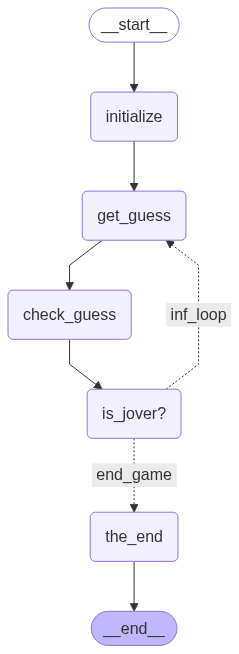

In [200]:
from IPython.display import Image, display
game_graph_object = create_game_graph({}) # Pass an empty dictionary as the initial state
display(Image(game_graph_object.get_graph().draw_mermaid_png(max_retries=3, retry_delay=2.0)))

In [201]:
print(type(input))

<class 'dict'>


In [202]:
def play_game():
  player_name = __builtins__.input("What's your name? ")

  starting_state = {
        "player_name": player_name,
        "hint": "",
        "target_number": 0,
        "guesses": [],
        "attempts": 0,
        "lower_bound": 1,
        "higher_bound": 100,
        "game_over": False,
        "won": False
  }
  config = RunnableConfig(recursion_limit=50)
  result = game_graph_object.invoke(starting_state, config)
  return result
  print(result)

# Chạy game thôi
if __name__ == "__main__":
    print("Welcome to the Higher-Lower Number Guessing Game!")
    print("=" * 50)
    play_game()

Welcome to the Higher-Lower Number Guessing Game!
What's your name? Chinh
Hi Chinh. I want to introduce you to this game. It's called Higher-Lower number guessing. Try to guess the number in the range of 1 to 100.
Attempt 1: Enter your guess: 42
Too high, dude. Try again.
You have 6 attempts remaining.
Attempt 2: Enter your guess: 40
Congrats. The number is 40, you guess is correct, pal. You win! 🎊
Again, congratulations! You, player Chinh, have won the game in 2 guesses! 🎉
Your guesses were: [42, 40]
Total attempts used: 2/7
